In [1]:
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_session_tbl
from utils.plot_utils import shiftedColorMap, template_reorder
from utils.ephys_functions import load_drift
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import shutil
from utils.beh_functions import get_unit_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar,merge_pdfs, combine_pdf_big
from joblib import Parallel, delayed
import spikeinterface.preprocessing as spre
%matplotlib inline

In [6]:
def waveform_check(session, data_type='curated', opto_only=True, units = None):
    sample_num = 10
    session_dir = session_dirs(session)
    analyzer_path = session_dir[f'postprocessed_dir_{data_type}']
    analyzer = si.load(analyzer_path, load_extensions=False)
    sparsity = analyzer.sparsity
    waveform_extractor = analyzer.get_extension("waveforms")
    random_spikes = analyzer.get_extension("random_spikes")
    unit_tbl = get_unit_tbl(session, data_type=data_type, summary=True)
    compressed_folder = session_dir['session_dir_raw']
    stream_name = 'ProbeA'
    recording_zarr = [os.path.join(compressed_folder, f) for f in os.listdir(compressed_folder) if stream_name in f and 'LFP' not in f][0]
    recording = si.read_zarr(recording_zarr)
    recording_ps = spre.phase_shift(recording, margin_ms=100.0)
    recording_bp = spre.bandpass_filter(recording_ps)
    recording_cr = spre.common_reference(recording_bp)

    channel_locations = analyzer.get_channel_locations()
    all_channels = analyzer.sparsity.channel_ids
    right_left = channel_locations[:, 0]<20
    
    if units is None:
        if opto_only:
            if 'opto_pass' not in unit_tbl.columns:
                print('No tagged units found in unit table. Please run `get_unit_tbl` with `summary=True`.')
                return
            if unit_tbl['opto_pass'].isnull().all() or not unit_tbl['tagged'].any():
                print(f'{session} No tagged units found.')
                return
            else:
                units = unit_tbl[unit_tbl['p_resp_']].unit_id.values
        else:
            units = unit_tbl.unit_id.values
    for unit in units:
        if os.path.exists(path=os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'waveforms_check', f'unit_{unit}_waveforms.pdf')):
            print(f'Unit {unit} already processed. Skipping...')
            continue
        waveforms = waveform_extractor.get_waveforms_one_unit(unit_id=unit)
        unit_channels_ind = sparsity.unit_id_to_channel_indices[unit]
        right_left_unit = right_left[unit_channels_ind]
        
        random_spikes_vector = random_spikes.get_selected_indices_in_spike_train(unit, segment_index=0)
        spike_times = unit_tbl[unit_tbl['unit_id'] == unit].spike_times.values[0]
        isi_v_ratio = unit_tbl[unit_tbl['unit_id'] == unit].isi_violations_ratio.values[0]
        amp = unit_tbl[unit_tbl['unit_id'] == unit].amp.values[0]
        peak = unit_tbl[unit_tbl['unit_id'] == unit].peak.values[0]
        snr = unit_tbl[unit_tbl['unit_id'] == unit].snr.values[0]
        # find peak waveform
        mean_wf  = np.squeeze(np.mean(waveforms, axis=0))
        wf_time = np.linspace(-3, 4, np.shape(waveforms)[1])
        peak_channel_id = np.argmax(np.ptp(mean_wf, axis=0))
        peak_waveform_mean = mean_wf[:, peak_channel_id]
        peak_waveforms = np.squeeze(waveforms[:, :, peak_channel_id])
        waveforms_sd = np.std(peak_waveforms, axis=0)
        waveforms_sem = waveforms_sd / np.sqrt(waveforms.shape[0])
        count = np.shape(waveforms)[0]

        # find major channel raw traces:
        peak_left_right = right_left_unit[peak_channel_id]
        unit_channels_major_ind = unit_channels_ind[right_left_unit == peak_left_right] # same side
        unit_channels_major_ind = unit_channels_major_ind[np.argsort(np.abs(unit_channels_major_ind-unit_channels_ind[peak_channel_id]))[:7]] # close to peak
        unit_channels_major_ind = np.sort(unit_channels_major_ind)
        recording_unit = recording_cr.select_channels(all_channels[unit_channels_major_ind])
        spike_samples = analyzer.sorting.get_unit_spike_train(unit_id = unit)
        unit_drift = load_drift(session, unit, data_type=data_type)
        if unit_drift is not None:
            if unit_drift['ephys_cut'] is not None:
                if unit_drift['ephys_cut'][0] is not None:
                    spike_samples = spike_samples[spike_times>= unit_drift['ephys_cut'][0]]
                    spike_times = spike_times[spike_times>= unit_drift['ephys_cut'][0]]
                if unit_drift['ephys_cut'][1] is not None:
                    spike_samples = spike_samples[spike_times<=unit_drift['ephys_cut'][1]]
                    spike_times = spike_times[spike_times<=unit_drift['ephys_cut'][1]]
        # pick 5 spikes evenly distributed in time
        pre_sample = 30000*0.01
        post_sample = 30000*0.01
        spike_times = spike_times[(spike_samples >= pre_sample) & (spike_samples <= (recording_unit.get_num_frames() - post_sample))]
        spike_samples = spike_samples[(spike_samples >= pre_sample) & (spike_samples <= (recording_unit.get_num_frames() - post_sample))]
        spike_inds = np.random.randint(0, len(spike_times), size = sample_num)  # upper bound is exclusive

        # plot
        bins = 6
        fig = plt.figure(figsize=(15, 3+sample_num*1.5))
        gs = gridspec.GridSpec(1+sample_num, 2+bins, height_ratios= [1] + [0.5]*sample_num)

        ax = fig.add_subplot(gs[0, 0])
        ax.plot(wf_time, peak_waveform_mean, color='k', label='mean')
        ax.fill_between(wf_time, peak_waveform_mean - waveforms_sd, 
                        peak_waveform_mean + waveforms_sd, color='k', alpha=0.2, label='sd', edgecolor='none')
        ax.fill_between(wf_time, peak_waveform_mean - waveforms_sem,
                        peak_waveform_mean + waveforms_sem, color='k', alpha=0.4, label='sem', edgecolor='none')
        ax.set_title(f'A: {amp :.1f}, P: {peak:.1f}')

        # separate into half and half
        edges = np.linspace(0, count, bins+1, dtype=int)
        upper_lim = np.max(peak_waveforms)
        lower_lim = np.min(peak_waveforms)
        for i in range(bins):
            ax = fig.add_subplot(gs[0, i+1])
            ax.plot(wf_time, peak_waveforms[edges[i]:edges[i+1], :].T, color = 'k', alpha=0.5, linewidth=0.2)
            ax.set_ylim(lower_lim, upper_lim)
            ax.set_title(f'Waveform {i+1}')

        # corr with mean 
        corr = [np.corrcoef(peak_waveforms[i, :], peak_waveform_mean)[0, 1] for i in range(count)]
        ax = fig.add_subplot(gs[0, -1])
        ax.hist(x=corr, bins=50, color='k', edgecolor='none', alpha=0.5)
        ax.set_title(f'Corr, Mean: {np.mean(corr):.2f}')
        # plot sample raw traces

        for sample_ind in range(sample_num):
            curr_sample_spike = spike_inds[sample_ind]
            start_frame = spike_samples[curr_sample_spike]-pre_sample
            stop_frame = spike_samples[curr_sample_spike]+post_sample
            curr_signal = recording_unit.get_traces(start_frame=start_frame,
                        end_frame=stop_frame,
                        return_scaled=True)
            ax = fig.add_subplot(gs[sample_ind+1,:])
            ax.imshow(curr_signal.T, extent=(-pre_sample/30, post_sample/30, 0, len(unit_channels_major_ind)),
                      aspect='auto', cmap='gray', interpolation='none')
            # get all spikes in this time window
            spike_samples_in_window = spike_samples[(spike_samples >= start_frame) & (spike_samples <= stop_frame)]
            spike_times_in_window = (spike_samples_in_window - spike_samples[curr_sample_spike])/ 30
            # plot them at vertical lines
            for spike_time in spike_times_in_window:
                ax.axvline(x=spike_time, color='r', linewidth=0.5)

        plt.suptitle(t=f'{session} Unit {unit} - ISI Violations Ratio: {isi_v_ratio:.3f}, SNR: {snr:.2f}')
        plt.tight_layout()
        os.makedirs(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'waveforms_check'), exist_ok=True)
        plt.savefig(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'waveforms_check', f'unit_{unit}_waveforms.pdf'))
    print('Done plotting waveforms for all units.')
    print('Combining PDFs...')
    # combine_pdf_big(session_dir[f'ephys_fig_dir_{data_type}'] + '/waveforms_check', os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'waveforms_check_combined.pdf'))


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1109: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.7 is recommended
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/spikeinterface/core/waveforms_extractor_backwards_compatibility.py:650: UserWarning: Removing legacy parameter return_scaled from spike_amplitudes extension
  warnings.warn(f"Removing legacy parameter {p} from {old_name} extension")
/opt/conda/lib/python3.10/site-packages/spikeinterface/core/waveforms_extractor_backwards_compatibility.py:650: UserWarning: Removing legacy parameter metrics_kwargs from template_metrics extension
  warnings.warn(f"Removing legacy parameter {p} from {old_name} extension")
/opt/conda/lib/python3.10/site-packages/spikeinterface/core/waveforms_extractor_backwards_compatibility.py:650: UserWarning: Removing legacy parameter method_kwargs from unit_locations extension
  warnings.warn(f"Removing legacy paramet

Done plotting waveforms for all units.
Combining PDFs...


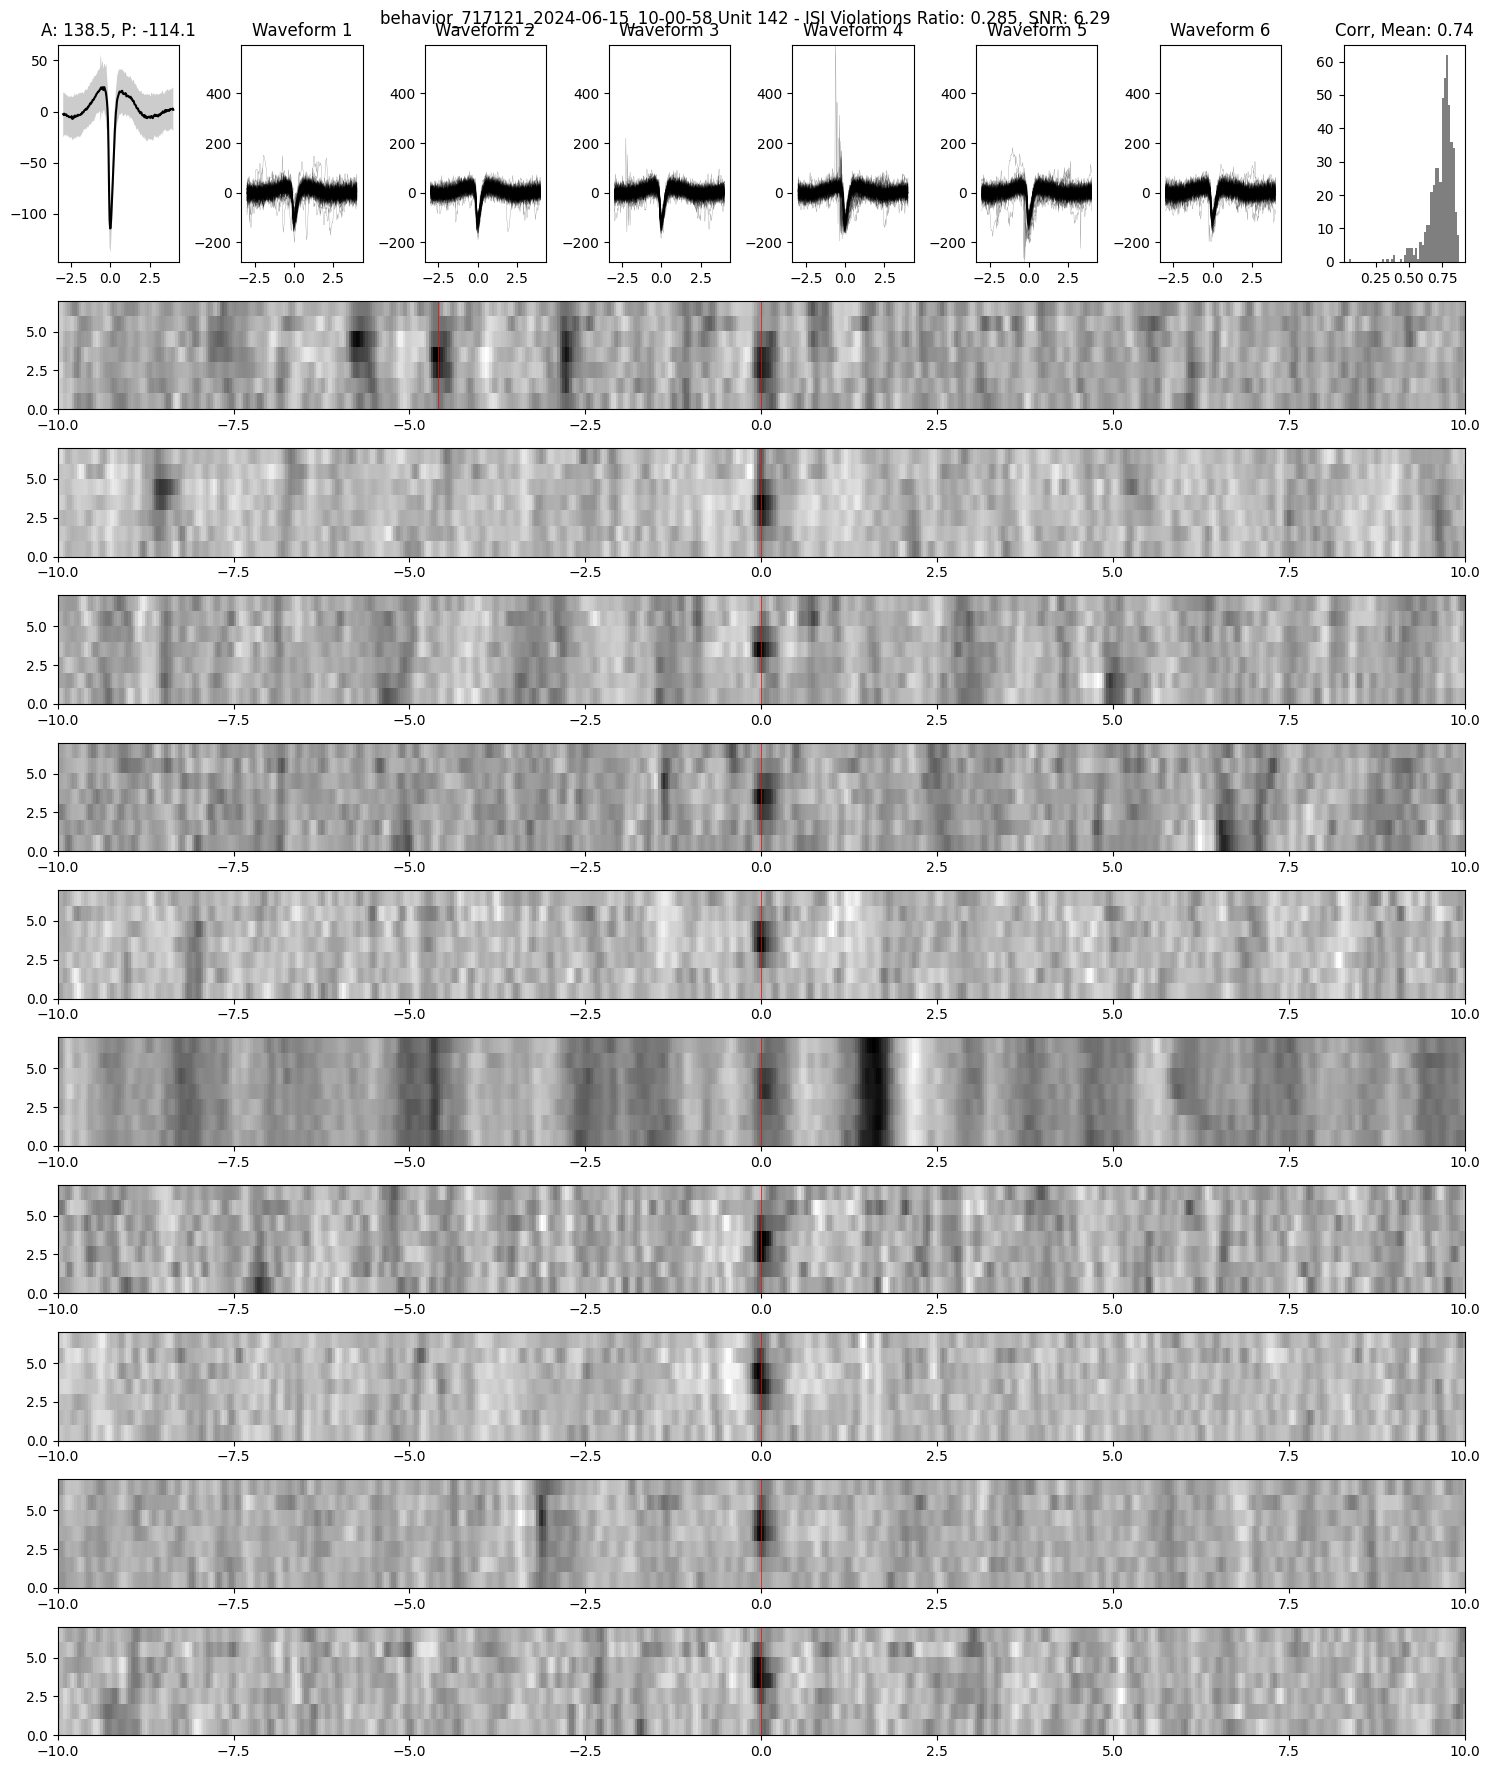

In [16]:
session = 'behavior_717121_2024-06-15_10-00-58'
data_type = 'curated'
opto_only = True
waveform_check(session, data_type=data_type, opto_only=opto_only, units = [142])

In [3]:
session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
session_list = session_assets['session_id']
session_list = [session for session in session_list if isinstance(session, str)]    

from joblib import Parallel, delayed
data_type = 'curated'
def process(session, data_type): 
    print(f'Starting {session}')
    session_dir = session_dirs(session)
    # if os.path.exists(os.path.join(session_dir['beh_fig_dir'], f'{session}.nwb')):
    print(session_dir[f'curated_dir_{data_type}'])
    if session_dir[f'curated_dir_{data_type}'] is not None:
        waveform_check(session, data_type=data_type, opto_only=True)
        print(f'Finished {session}')
    else:
        print(f'No curated data found for {session}') 
    # elif session_dir['curated_dir_raw'] is not None:
    #     data_type = 'raw' 
    #     opto_tagging_df_sess = opto_plotting_session(session, data_type, target, resp_thresh=resp_thresh, lat_thresh=lat_thresh, target_unit_ids= None, plot = True, save=True)
Parallel(n_jobs=5)(delayed(process)(session, data_type) for session in session_list[82:94])
# process('ecephys_763360_2025-04-16_13-29-55', data_type)
# for session in session_list[3:]:
#     if isinstance(session, str):
#         process(session, data_type)
#     else:
#         print(f'Skipping {session} as it is not a string')

Starting behavior_782394_2025-04-22_10-53-28
Starting behavior_782394_2025-04-23_10-51-17
Starting behavior_763590_2025-05-01_10-59-18
Starting behavior_782394_2025-04-25_11-13-21
Starting behavior_782394_2025-04-24_12-07-34
/root/capsule/data/behavior_782394_2025-04-22_10-53-28_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/behavior_763590_2025-05-01_10-59-18_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/behavior_782394_2025-04-25_11-13-21_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/behavior_782394_2025-04-23_10-51-17_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
/root/capsule/data/behavior_782394_2025-04-24_12-07-34_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1


behavior_782394_2025-04-22_10-53-28 No tagged units found.
Finished behavior_782394_2025-04-22_10-53-28
Starting behavior_763590_2025-05-02_11-07-09
/root/capsule/data/behavior_763590_2025-05-02_11-07-09_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1
Done plotting waveforms for all units.
Combining PDFs...
Processing 17 files in /root/capsule/scratch/782394/behavior_782394_2025-04-25_11-13-21/ephys/curated/figures/waveforms_check
Combined PDF saved as: /root/capsule/scratch/782394/behavior_782394_2025-04-25_11-13-21/ephys/curated/figures/waveforms_check_combined.pdf
Finished behavior_782394_2025-04-25_11-13-21
Starting behavior_781166_2025-05-13_14-04-27
/root/capsule/data/behavior_781166_2025-05-13_14-04-27_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1


/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_10651/30176703.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
/tmp/ipykernel_10651/30176703.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.cl

Done plotting waveforms for all units.
Combining PDFs...
Processing 18 files in /root/capsule/scratch/763590/behavior_763590_2025-05-02_11-07-09/ephys/curated/figures/waveforms_check


/tmp/ipykernel_10651/30176703.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Combined PDF saved as: /root/capsule/scratch/763590/behavior_763590_2025-05-02_11-07-09/ephys/curated/figures/waveforms_check_combined.pdf
Finished behavior_763590_2025-05-02_11-07-09


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Starting behavior_781166_2025-05-14_14-18-28
/root/capsule/data/behavior_781166_2025-05-14_14-18-28_sorted_curated/curated/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1


/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Done plotting waveforms for all units.
Combining PDFs...
Processing 46 files in /root/capsule/scratch/763590/behavior_763590_2025-05-01_10-59-18/ephys/curated/figures/waveforms_check


MemoryError: Unable to allocate 1.29 GiB for an array with shape (63503, 210, 26) and data type float32